In [167]:
import pandas as pd 
import numpy as np
from datasets import CRSP
import matplotlib.pyplot as plt
from itertools import combinations
from tqdm import tqdm


In [168]:
crsp = CRSP()

df = crsp.df[['permno', 'date', 'ticker', 'prc', 'ret']].copy()

df = df.query("prc > 5").reset_index(drop=True)

df

,permno,date,ticker,prc,ret
0,10001,1986-02-28,GFGC,6.25000,0.020408
1,10001,1986-03-31,GFGC,6.31250,0.025200
2,10001,1986-04-30,GFGC,6.37500,0.009901
3,10001,1986-05-30,GFGC,6.31250,-0.009804
4,10001,1986-06-30,GFGC,6.12500,-0.013069
...,...,...,...,...,...
2844782,93436,2023-08-31,TSLA,258.07999,-0.034962
2844783,93436,2023-09-29,TSLA,250.22000,-0.030456
2844784,93436,2023-10-31,TSLA,200.84000,-0.197346
2844785,93436,2023-11-30,TSLA,240.08000,0.195379


In [169]:
# Formation Period: 12 months
# Use cummulative returns from t-13 to t-1 to form pairs.
# Rebalancing: Every 6 months

In [170]:
# Add extra date variables
df['mdt'] = df['date'].dt.strftime("%Y-%m")
df['year'] = df['date'].dt.strftime("%Y")
df['month'] = df['date'].dt.strftime("%m")

In [171]:
# Calculate Different Return Variables

holding_period = 6 # Alternative is 1
holding_period_var = f'ret_{holding_period}'

# Log Returns
df['logret'] = np.log1p(df['ret'])
df['cumret'] = df.groupby(['permno','year'])['logret'].cumsum().reset_index(drop=True)
df['cumret_lag'] = df.groupby('permno')['cumret'].shift(1)

# Holding period returns
df[holding_period_var] = df.groupby('permno')['logret'].rolling(holding_period,holding_period).sum().reset_index(drop=True)
df[holding_period_var] = df.groupby('permno')[holding_period_var].shift(-(holding_period-1))

df

,permno,date,ticker,prc,ret,mdt,year,month,logret,cumret,cumret_lag,ret_6
0,10001,1986-02-28,GFGC,6.25000,0.020408,1986-02,1986,02,0.020203,0.020203,NaN,0.021679
1,10001,1986-03-31,GFGC,6.31250,0.025200,1986-03,1986,03,0.024888,0.045090,0.020203,0.071156
2,10001,1986-04-30,GFGC,6.37500,0.009901,1986-04,1986,04,0.009852,0.054943,0.045090,0.043187
3,10001,1986-05-30,GFGC,6.31250,-0.009804,1986-05,1986,05,-0.009852,0.045090,0.054943,0.071801
4,10001,1986-06-30,GFGC,6.12500,-0.013069,1986-06,1986,06,-0.013155,0.031935,0.045090,0.136713
...,...,...,...,...,...,...,...,...,...,...,...,...
2844782,93436,2023-08-31,TSLA,258.07999,-0.034962,2023-08,2023,08,-0.035588,0.739624,0.775212,NaN
2844783,93436,2023-09-29,TSLA,250.22000,-0.030456,2023-09,2023,09,-0.030929,0.708694,0.739624,NaN
2844784,93436,2023-10-31,TSLA,200.84000,-0.197346,2023-10,2023,10,-0.219832,0.488863,0.708694,NaN
2844785,93436,2023-11-30,TSLA,240.08000,0.195379,2023-11,2023,11,0.178463,0.667326,0.488863,NaN


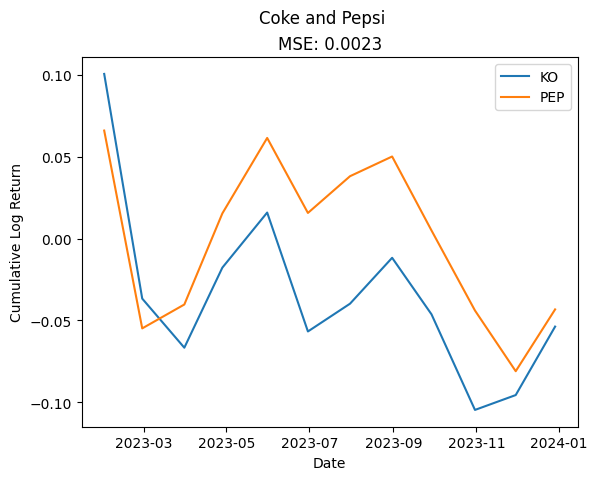

In [172]:
# Example of Pepsi and Coke cointegration
filtered = df[(df['year'] == '2023') & (df['permno'].isin([13856, 11308]))]
pivot = filtered.pivot(index='date', values='cumret_lag', columns='ticker')
mse = np.mean((pivot['PEP'] - pivot['KO'])**2)

for ticker, group in filtered.groupby('ticker'):
    plt.plot(group['date'], group['cumret_lag'], label=ticker)

plt.xlabel('Date')
plt.ylabel('Cumulative Log Return')
plt.suptitle('Coke and Pepsi')
plt.title(f"MSE: {round(mse,4)}")
plt.legend()
plt.show()

In [187]:
pivot = df.groupby(['permno','date'])['cumret_lag'].mean().reset_index().pivot(index='date', columns='permno', values='cumret_lag')
pivot['year'] = pivot.index.year
pivot

permno,10001,10002,10003,10006,10007,10008,10009,10010,10011,10012,...,93423,93426,93428,93429,93432,93433,93434,93435,93436,year
date,,,,,,,,,,,,,,,,,,,,,
1926-01-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1926
1926-02-27,NaN,NaN,NaN,0.032208,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1926
1926-03-31,NaN,NaN,NaN,-0.041901,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1926
1926-04-30,NaN,NaN,NaN,-0.085576,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1926
1926-05-28,NaN,NaN,NaN,-0.111824,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1926
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.027572,-0.032608,NaN,NaN,NaN,NaN,NaN,NaN,0.775212,2023
2023-09-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.012553,-0.070472,NaN,NaN,NaN,NaN,NaN,NaN,0.739624,2023
2023-10-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.011119,-0.140616,NaN,NaN,NaN,NaN,NaN,NaN,0.708694,2023


In [198]:
# years = pivot['year'].unique()  # [2017, 2018]

# mse_frame = pd.DataFrame(index=years, columns=pivot.columns[:-1], data=float("inf"))
# pairs_frame = pd.DataFrame(index=years, columns=pivot.columns[:-1], data=None)

# # Iterated through each year of data
# for year in tqdm(years, desc='Processing years'):
#     slice = pivot[pivot['year'] == year].dropna(axis=1, how='all').drop(columns=['year'])
    
#     returns = slice.dropna(axis=1).T.dropna().T # This gets rid of stocks without 12 months of returns
#     returns_array = returns.values
    
#     # Loop through all combination of pairs
#     for i, j in combinations(range(returns_array.shape[1]), 2):
#         stock_i = returns.columns[i]
#         stock_j = returns.columns[j]
        
#         stock_i_returns = returns_array[:, i]
#         stock_j_returns = returns_array[:, j]

#         mse = np.mean((stock_i_returns - stock_j_returns) ** 2)

#         # Keep pairs with the lowest MSE
#         if mse < mse_frame.at[year, stock_i]:
#             mse_frame.at[year, stock_i] = mse
#             pairs_frame.at[year, stock_i] = returns.columns[j]

# pairs_frame.to_csv("pairs_frame.csv")
# mse_frame.to_csv("mse_frame.csv")


Processing years: 100%|██████████| 2/2 [00:31<00:00, 15.62s/it]


In [214]:
pairs_frame = pd.read_csv("pairs_frame.csv", index_col=0)
mse_frame = pd.read_csv("mse_frame.csv", index_col=0)

In [215]:
# # Reformat mse and pairs dataframes
# result_pairs_frame = pairs_frame.unstack().reset_index().rename(columns={'level_0': 'permno','level_1': 'year', 0: 'pair'})
# result_mse_frame = mse_frame.unstack().reset_index().rename(columns={'level_0': 'permno','level_1':'year', 0: 'mse'})

# # Merge
# merged = result_mse_frame.merge(result_pairs_frame, on=['permno','year'], how='left')

# # Clean up final dataframe
# merged = merged.sort_values(by=['year','mse'], ascending=True).dropna().reset_index(drop=True)

# merged['permno'] = merged['permno'].astype(int)
# merged['pair'] = merged['pair'].astype(int)

# merged.to_csv("pairs_yearly.csv",index=False)

# merged

In [216]:
merged = pd.read_csv("pairs_yearly.csv")

merged

,permno,year,mse,pair
0,10268,1926,0.009464,11666
1,10241,1926,0.018210,10268
2,11092,1926,0.021678,11666
3,11666,1926,0.255773,12319
4,10225,1927,0.000033,10428
...,...,...,...,...
196516,91907,2023,0.226655,92089
196517,16824,2023,0.335257,23064
196518,92213,2023,0.353288,93436
196519,93426,2023,0.507867,93436


1926.0 11092.0 11666.0


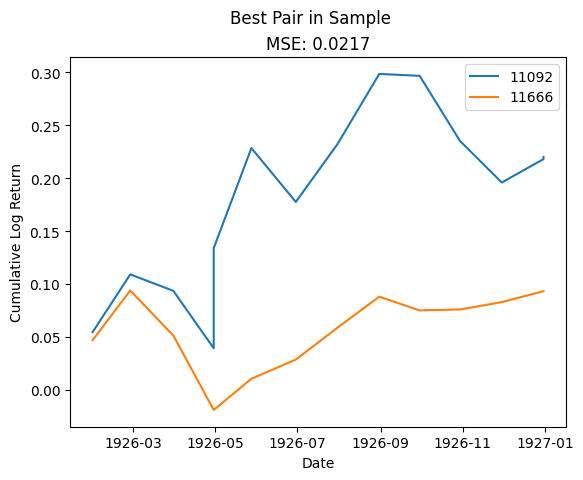

In [217]:
pair_1, year, mse, pair_2 = merged.iloc[2]
print(year, pair_1, pair_2)
filtered = df[(df['year'].astype(int) == year) & (df['permno'].isin([pair_1,pair_2]))]

for permno, group in filtered.groupby('permno'):
    plt.plot(group['date'], group['cumret_lag'], label=permno)

plt.xlabel('Date')
plt.ylabel('Cumulative Log Return')
plt.suptitle('Best Pair in Sample')
plt.title(f"MSE: {round(mse,4)}")
plt.legend()
plt.show()

In [218]:
filtered

,permno,date,ticker,prc,ret,mdt,year,month,logret,cumret,cumret_lag,ret_6
121036,11092,1926-01-30,None,64.875,0.056112,1926-01,1926,01,0.054594,0.054594,NaN,0.228487
121037,11092,1926-01-30,None,64.875,0.056112,1926-01,1926,01,0.054594,0.109188,0.054594,0.123002
121038,11092,1926-02-27,None,63.875,-0.015414,1926-02,1926,02,-0.015534,0.093654,0.109188,0.123109
121039,11092,1926-03-31,None,60.500,-0.052838,1926-03,1926,03,-0.054285,0.039369,0.093654,0.204843
121040,11092,1926-04-30,None,65.500,0.099174,1926-04,1926,04,0.094559,0.133928,0.039369,0.257322
121041,11092,1926-04-30,None,65.500,0.099174,1926-04,1926,04,0.094559,0.228487,0.133928,0.101233
121042,11092,1926-05-28,None,62.250,-0.049618,1926-05,1926,05,-0.050891,0.177596,0.228487,-0.032547
121043,11092,1926-06-30,None,65.750,0.056225,1926-06,1926,06,0.054701,0.232297,0.177596,0.040456
121044,11092,1926-07-31,None,69.250,0.068441,1926-07,1926,07,0.066201,0.298498,0.232297,-0.012259
121045,11092,1926-08-31,None,69.125,-0.001805,1926-08,1926,08,-0.001807,0.296691,0.298498,-0.076474


In [219]:
merged

,permno,year,mse,pair
0,10268,1926,0.009464,11666
1,10241,1926,0.018210,10268
2,11092,1926,0.021678,11666
3,11666,1926,0.255773,12319
4,10225,1927,0.000033,10428
...,...,...,...,...
196516,91907,2023,0.226655,92089
196517,16824,2023,0.335257,23064
196518,92213,2023,0.353288,93436
196519,93426,2023,0.507867,93436


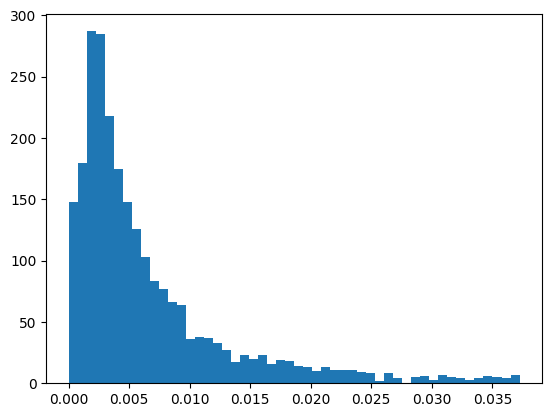

In [220]:
two_std = merged['mse'].std() * 2
test = merged[(merged['year'] == 2023) & (merged['mse'] < two_std)]
plt.hist(test['mse'], bins = 50)
plt.show()

In [221]:
test = merged[merged['year'] == 2023].reset_index(drop=True)
test = test[test.index < 20]

test

,permno,year,mse,pair
0,22898,2023,0.000008,23511
1,22693,2023,0.000009,23052
2,23025,2023,0.000009,23049
3,20915,2023,0.000010,22898
4,22773,2023,0.000010,23183
5,22769,2023,0.000010,23025
6,22791,2023,0.000010,23011
7,21628,2023,0.000011,22791
8,22616,2023,0.000011,22881
9,22563,2023,0.000011,23011
